# **Training an NLP on Habitual Be**
##A First Step Towards an AAVE-literate Language Learning Model




## Abstract

African American Vernacular English (AAVE), like other forms of English, has its own unique grammatical structures, vocabulary, and usage patterns. Despite being a defining part of American culture, language learning models have yet to incorporate an understanding and usage of AAVE.

Furthermore, as AI becomes more a part of our daily lives, it behooves us to do whatever we can to prevent already intrinsic biases from expanding in reach and power. Timnit Gebru and others have already rung the alarm on the dangers of reifying hegemony and harming already marginalized populations through use of large datasets culled from the Internet. In "[On the Dangers of Stochastic Parrots: Can Language Models Be Too Big?](https://dl.acm.org/doi/pdf/10.1145/3442188.3445922)" the authors  **"recommend
mitigating these risks by budgeting for curation and documentation
at the start of a project and only creating datasets as large as can
be sufficiently documented."**

I have attempted to do just that through creating my own corpus wherein each sentence has been carefully selected, (in some cases) edited, and tagged by me. When compiling the corpus, I chose to pull from text written by Black people who are native speakers of African American Vernacular English (AAVE) for the text tagged as habitual be. The text tagged as present be contains sentences mostly composed by Black people who are native speakers of AAVE as well as text composed by people of various racial and ethnic backgrounds who only or primarily communicate using Standard American English (SAE).


Thus far, the Multinomial Naive Bayes model is the most adept of the models I have tried at distinguishing between a sentence employing habitual be and one using present be.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Load Dependencies

In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk.collocations as collocations


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,\
precision_recall_fscore_support, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###Reading in the data

In [5]:
corpus = pd.read_csv('/content/gdrive/MyDrive/AAVE-Corpus/habitual_be_present_be_corpus_numerical_target.csv')

### **Preprocessing**

Cleaning and tokenizing the text involved creating a custom tokenizer to remove punctuation and lemmatize and tag the text. I made the choice to keep stopwords. Not only is my target a stop word, I believe the other English stopwords are important for interpreting context for this model.

####Defining functions for preprocessing

In [ ]:
# Custom tokenizer
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
     # Convert to lowercase
    text = text.lower()
    # Tokenize by splitting the text on whitespace
    tokens = text.split()

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return ' '.join(lemmatized_words)

    # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:
# Preprocess text and create new column with said text
corpus['processed_text'] = corpus['text'].apply(preprocess_text)

###**Exploratory Data Analysis + Visualizations**

As discussed in the abstract, in order to mitigate potential biases, the present be text comes primarily from Black people who are native speakers of AAVE, while the habitual be text comes only from Black people who are native speakers of AAVE.

I made this choice in order to mitigate any bias that could result from  restricting present be contributions to non-Black sources not conversant in AAVE. When conducting my exploratory data analysis, I first looked at the whole corpus, then I looked at the habitual be and present be text separately in order to get a sense of how successful I was at addressing this concern.

#### Whole Corpus

In [ ]:
# Tokenize text by words for each row in the 'processed_text' column
corpus['tokenized_text'] = corpus['processed_text'].apply(lambda x: word_tokenize(x))

# Check the number of words by summing the lengths of the tokenized lists
total_words = corpus['tokenized_text'].apply(len).sum()
print(f"The total number of words in the text is {total_words}")

The total number of words in the text is 29210


In [ ]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in corpus['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(10))

[('be', 2732), ('they', 1351), ('to', 824), ('the', 819), ('i', 577), ('a', 517), ('and', 463), ('it', 384), ('in', 335), ('you', 321)]


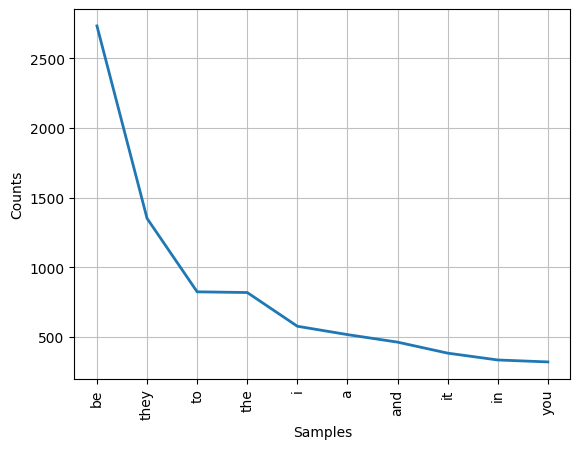

In [ ]:
#Plot the 10 most common words
freq_dist.plot(10)
plt.show();

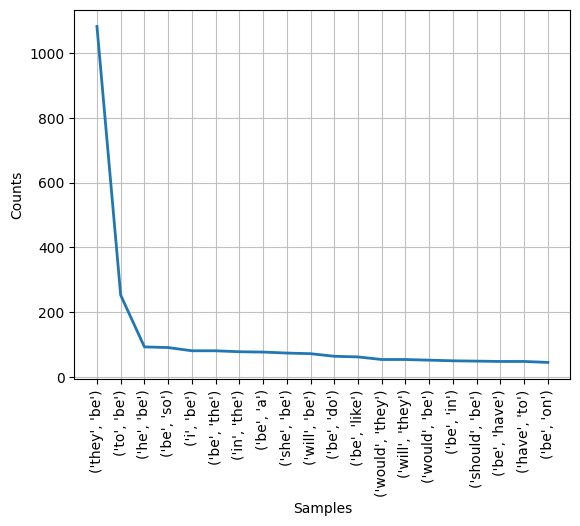

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

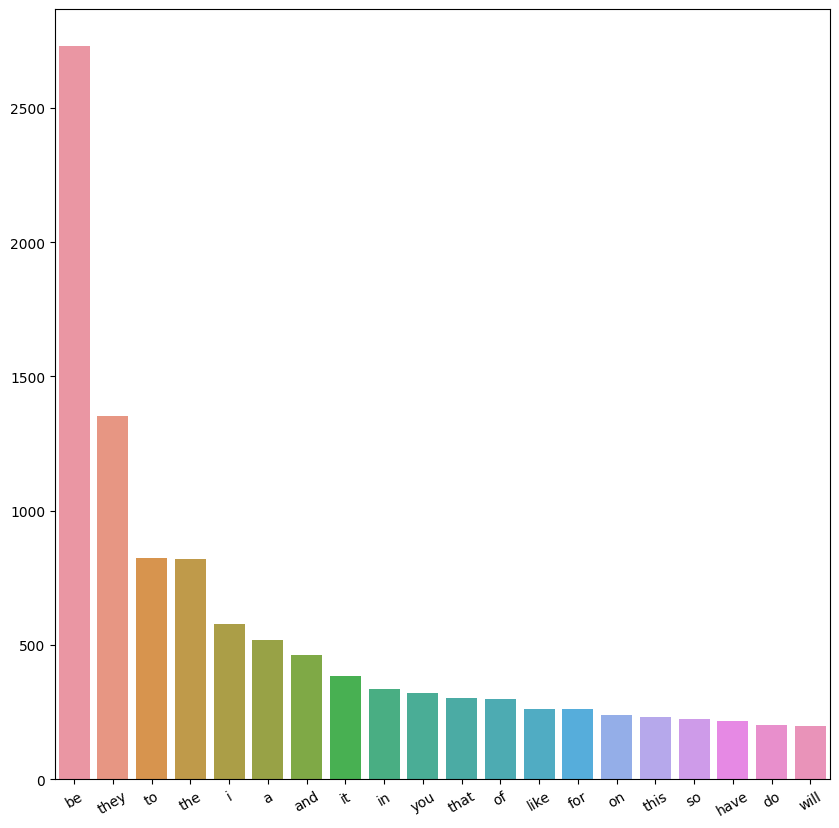

In [ ]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

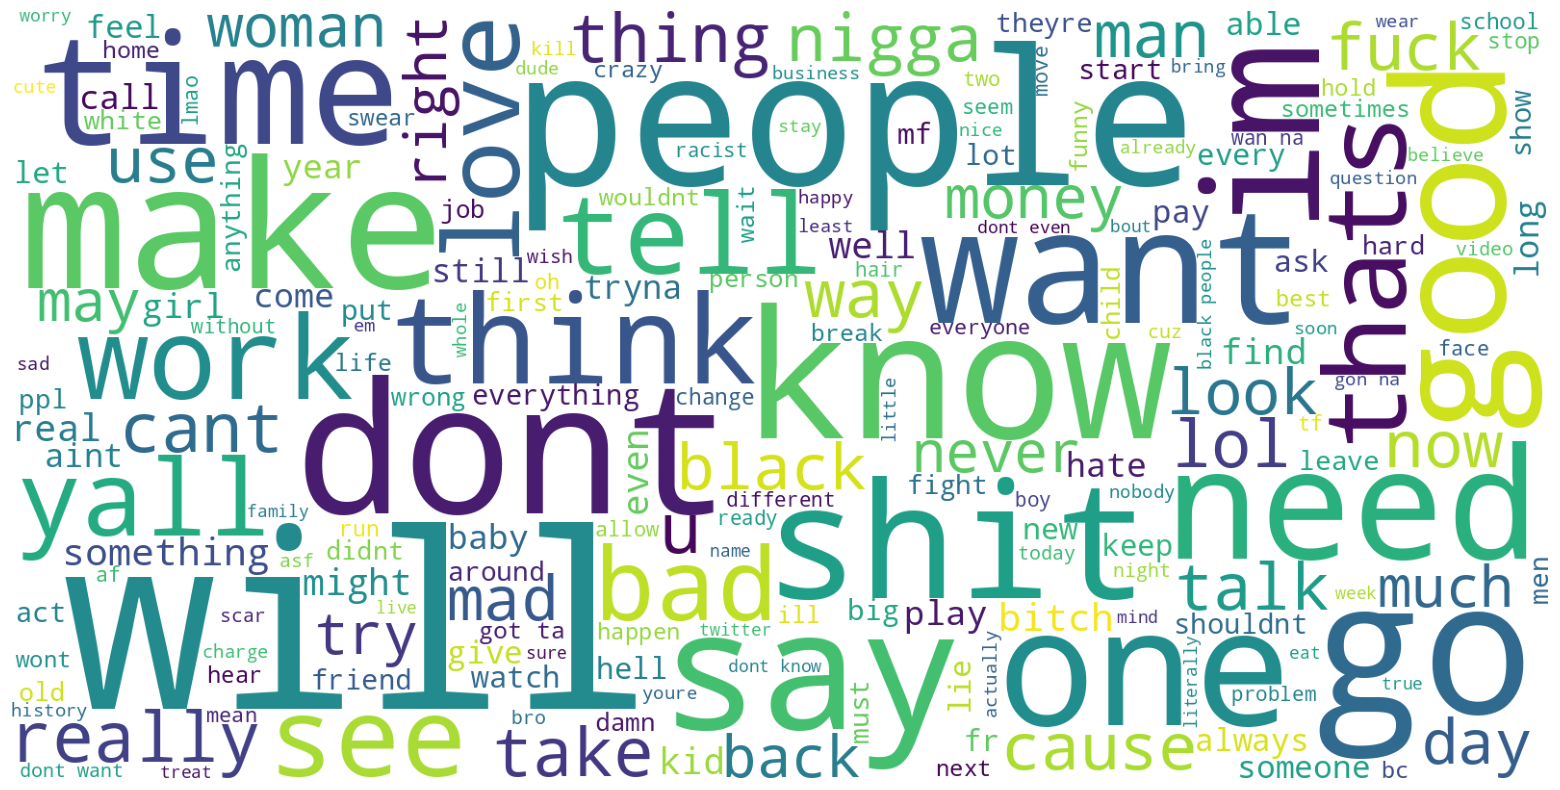

In [ ]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

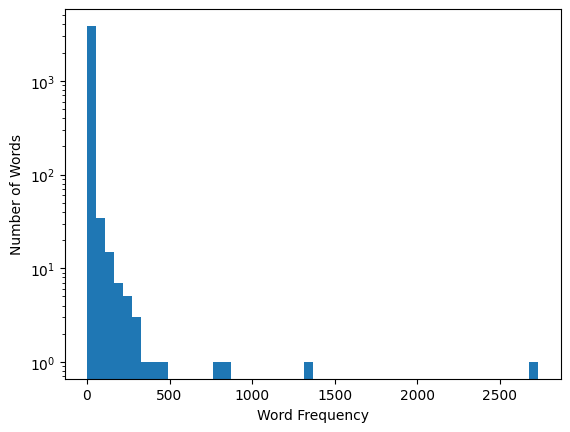

In [ ]:
# Vectorize the text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus['processed_text'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

#### Habitual Be

In [ ]:
# Filter the DataFrame to include only rows where the target is 1
filtered_corpus_habitual = corpus[corpus['target'] == 1]

# Combine all the tokenized words from the filtered DataFrame into a single list
habitual_be_words = [word for tokenized_text in filtered_corpus_habitual['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist_h = FreqDist(habitual_be_words)

# Print the top ten words
print(freq_dist_h.most_common(10))


[('be', 1334), ('they', 958), ('the', 361), ('i', 346), ('to', 270), ('and', 234), ('like', 207), ('a', 204), ('it', 170), ('you', 160)]


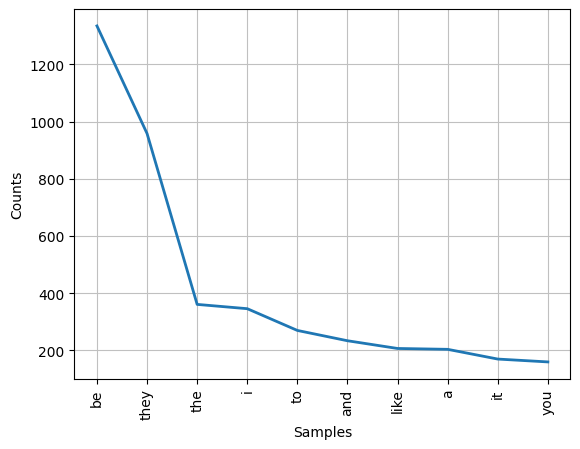

In [ ]:
#Plot the 10 most common words
freq_dist_h.plot(10)
plt.show();

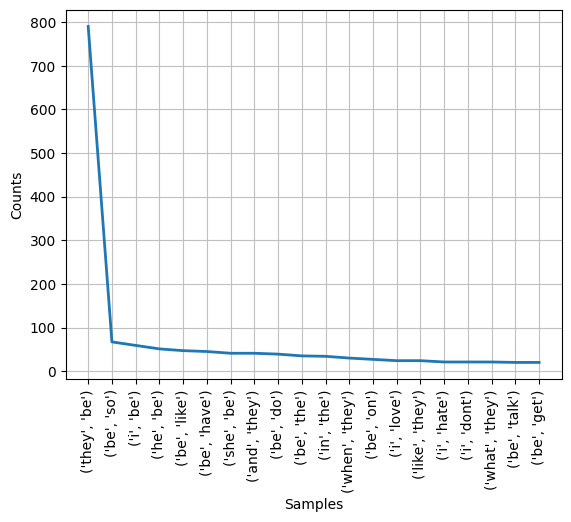

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
bigrams_h = nltk.bigrams(habitual_be_words)
tokenized_bigrams_h = nltk.FreqDist(bigrams_h)
tokenized_bigrams_h.most_common(20)
tokenized_bigrams_h.plot(20)

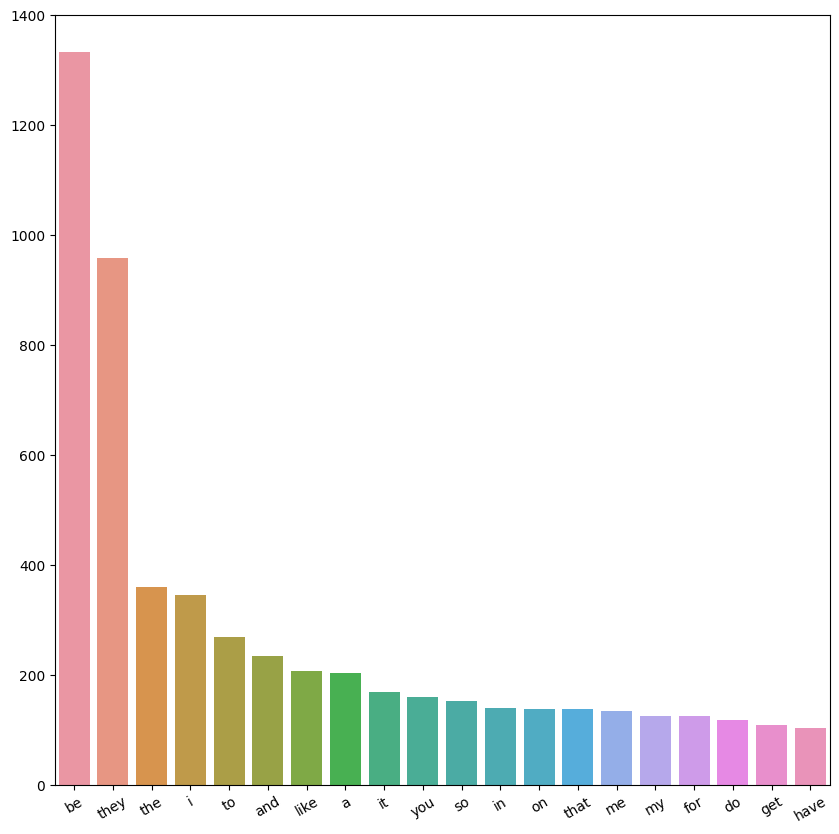

In [ ]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
h_fdist = FreqDist(habitual_be_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
h_fdist = pd.Series(dict(h_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
h_plot = sns.barplot(x=h_fdist.index, y=h_fdist.values, ax=ax)
plt.xticks(rotation=30);

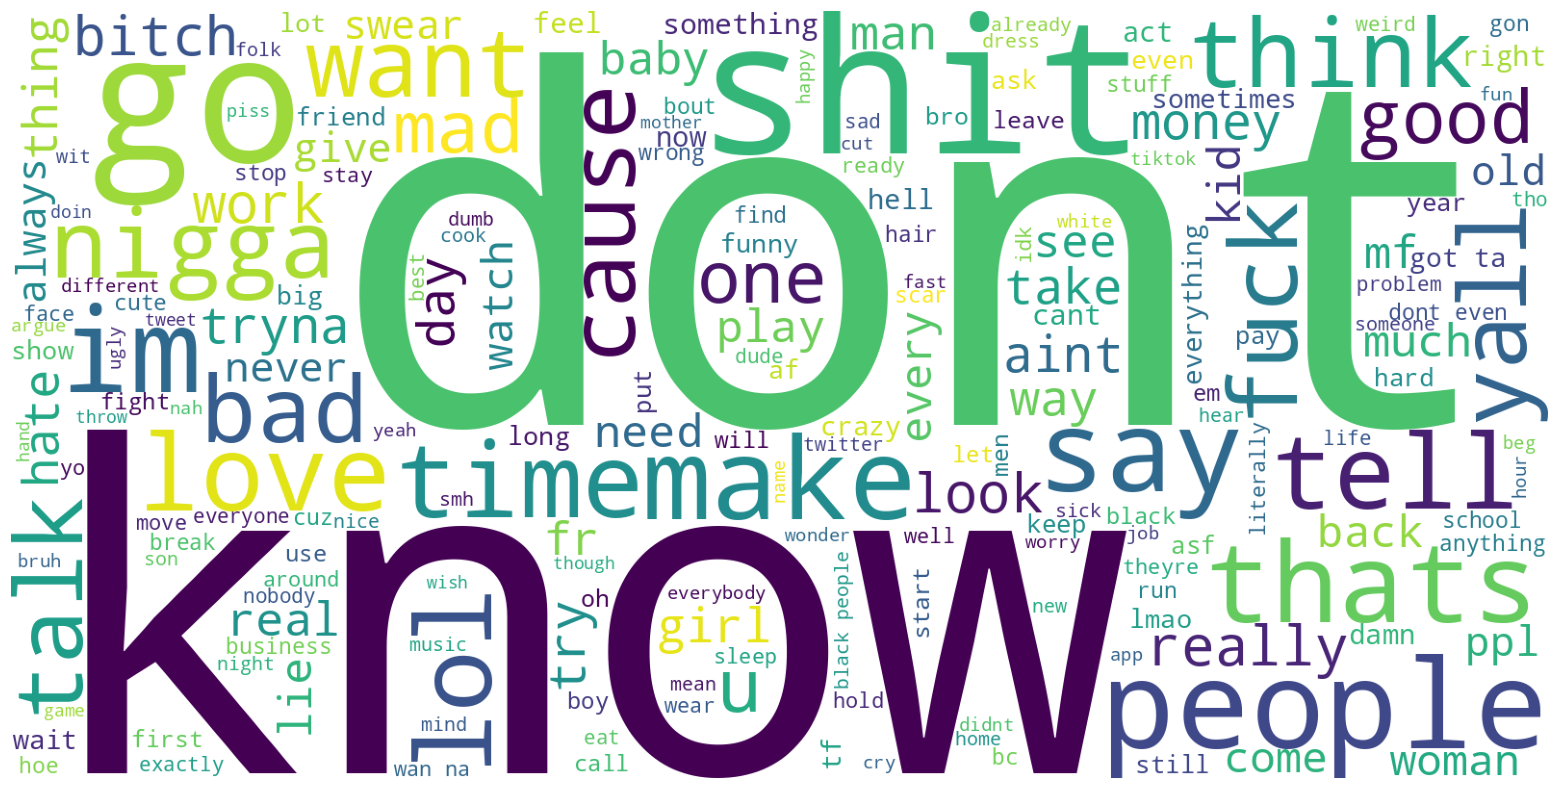

In [ ]:
#Convert word list to a single string
words_string_h = " ".join(habitual_be_words)

#generating the wordcloud
wordcloud_h = WordCloud(background_color="white", width=1600, height=800).generate(words_string_h)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_h)

#to remove the axis value
plt.axis("off")
plt.show();

#### Present Be

In [ ]:
# Filter the DataFrame to include only rows where the target is 1
filtered_corpus_present = corpus[corpus['target'] == 0]

# Combine all the tokenized words from the filtered DataFrame into a single list
present_be_words = [word for tokenized_text in filtered_corpus_present['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist_p = FreqDist(present_be_words)

# Print the top ten words
print(freq_dist_p.most_common(10))


[('be', 1398), ('to', 554), ('the', 458), ('they', 393), ('a', 313), ('i', 231), ('and', 229), ('of', 216), ('it', 214), ('in', 194)]


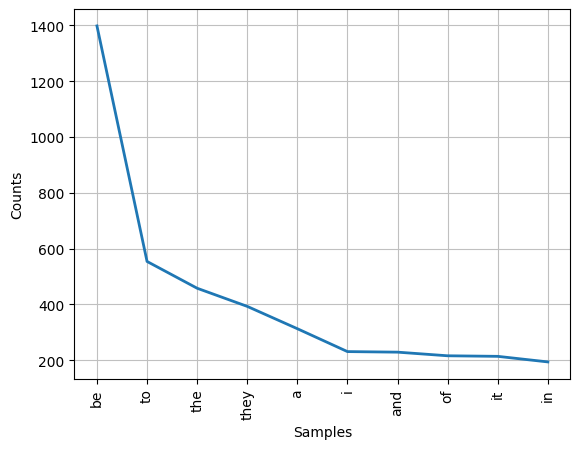

In [ ]:
#Plot the 10 most common words
freq_dist_p.plot(10)
plt.show();

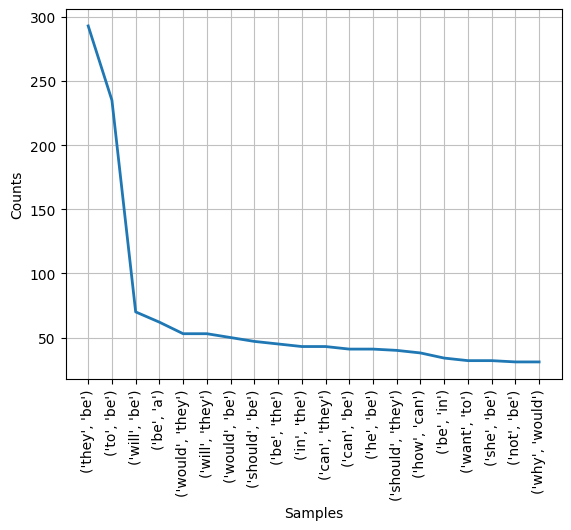

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
bigrams_p = nltk.bigrams(present_be_words)
tokenized_bigrams_p = nltk.FreqDist(bigrams_p)
tokenized_bigrams_p.most_common(20)
tokenized_bigrams_p.plot(20)

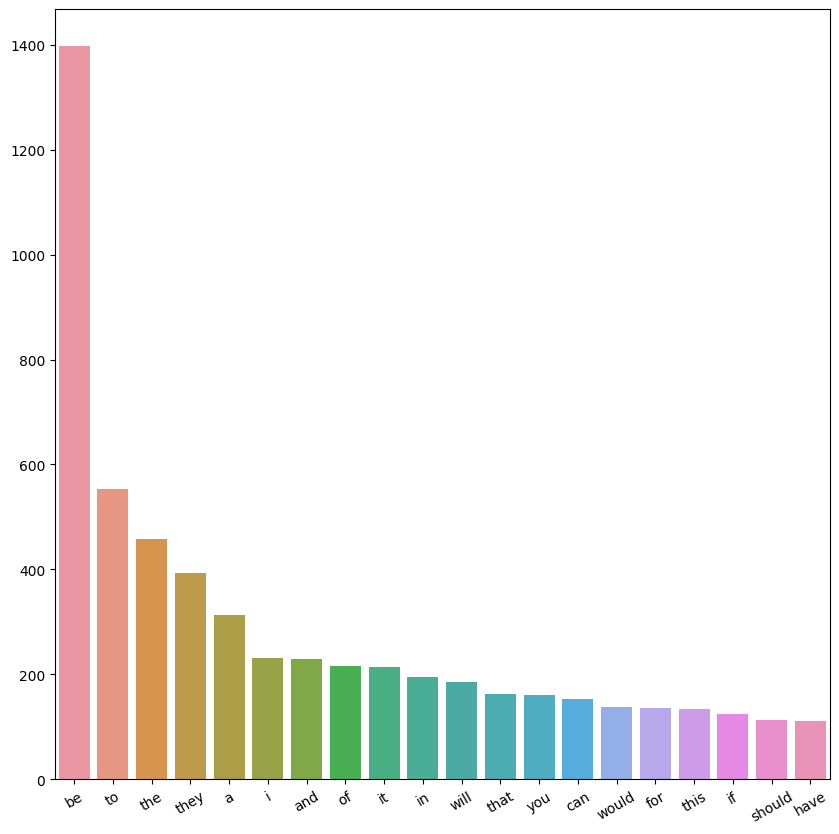

In [ ]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
p_fdist = FreqDist(present_be_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
p_fdist = pd.Series(dict(p_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
p_plot = sns.barplot(x=p_fdist.index, y=p_fdist.values, ax=ax)
plt.xticks(rotation=30);

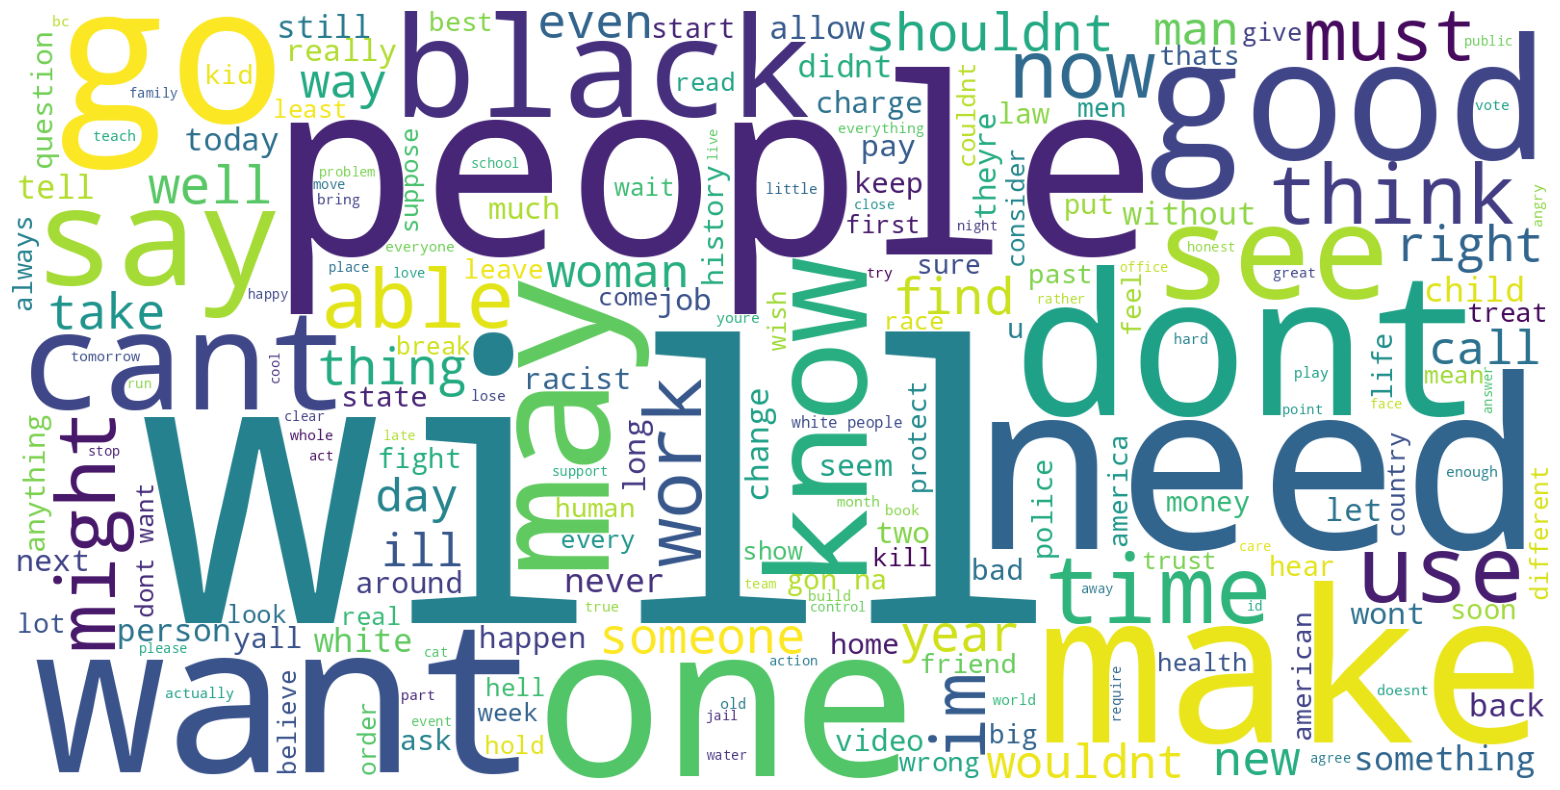

In [ ]:
#Convert word list to a single string
words_string_p = " ".join(present_be_words)

#generating the wordcloud
wordcloud_p = WordCloud(background_color="white", width=1600, height=800).generate(words_string_p)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_p)

#to remove the axis value
plt.axis("off")
plt.show();

####Data Visualization Main Takeaways



*   Bigrams are likely to be a key piece of vectorizing the text.
*   I noted some promising signs of balance between the habitual be and present be texts:
  *   The top ten words used in both are similar in that each only contains two words not found in the other.
  *   The top bigrams have 'they be' in the lead for both, which is also what I wanted. This combination occurs frequently in AAVE and SAE, but communicate distinct meanings. Learning to differentiate the two will be key for any model trained on AAVE. The rest differ, which is also as it should be. The bar charts with the top 20 words provide an easier to read illustration of this distribution.

* There are more curse words in the habitual be text, which is a common occurrence in many forms of vernacular. Creating a balance of this may or may not improve model performance, and is worth considering.


### **Model Iterations**

####Creating train, test, and validation sets

In [ ]:
X = corpus.processed_text
y = corpus.target

In [ ]:
# Shuffle and split into training and test set (80-20 split)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Split the training set into training and validation sets (75-25 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_train_temp)

####Defining functions for evaluation metrics

In [ ]:
# Function for evaluation metrics
def print_scores(pipe, X_train, X_val, X_test, y_train, y_val, y_test):
    # Training set predictions
    y_train_pred = pipe.predict(X_train)
    train_results_dict = {'accuracy': accuracy_score(y_train, y_train_pred),
                          'recall': recall_score(y_train, y_train_pred),
                          'precision': precision_score(y_train, y_train_pred),
                          'f1_score': f1_score(y_train, y_train_pred)}

    # Validation set predictions
    y_val_pred = pipe.predict(X_val)
    val_results_dict = {'accuracy': accuracy_score(y_val, y_val_pred),
                        'recall': recall_score(y_val, y_val_pred),
                        'precision': precision_score(y_val, y_val_pred),
                        'f1_score': f1_score(y_val, y_val_pred)}

    # Test set predictions
    y_test_pred = pipe.predict(X_test)
    test_results_dict = {'accuracy': accuracy_score(y_test, y_test_pred),
                         'recall': recall_score(y_test, y_test_pred),
                         'precision': precision_score(y_test, y_test_pred),
                         'f1_score': f1_score(y_test, y_test_pred)}

    return train_results_dict, val_results_dict, test_results_dict


In [ ]:
# Function for final model evaluation metrics
def print_final_scores(pipe, X_train, X_test, y_train, y_test):
    # Training set predictions
    y_train_pred = pipe.predict(X_train)
    train_results_dict = {'accuracy': accuracy_score(y_train, y_train_pred),
                          'recall': recall_score(y_train, y_train_pred),
                          'precision': precision_score(y_train, y_train_pred),
                          'f1_score': f1_score(y_train, y_train_pred)}

    # Test set predictions
    y_test_pred = pipe.predict(X_test)
    test_results_dict = {'accuracy': accuracy_score(y_test, y_test_pred),
                         'recall': recall_score(y_test, y_test_pred),
                         'precision': precision_score(y_test, y_test_pred),
                         'f1_score': f1_score(y_test, y_test_pred)}

    return train_results_dict, test_results_dict

###Baseline Model — Logistic Regression

In [ ]:
# Define the pipeline
lrpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
lrpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg', LogisticRegression(random_state=42))])

####Evaluating Logistic Regression Model

In [ ]:
train_results, val_results, test_results = print_scores(lrpipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.99
recall: 0.995
precision: 0.9851485148514851
f1_score: 0.9900497512437811

Validation set results:
accuracy: 0.9
recall: 0.915
precision: 0.8883495145631068
f1_score: 0.9014778325123154

Test set results:
accuracy: 0.915
recall: 0.92
precision: 0.9108910891089109
f1_score: 0.9154228855721394


####Hyperparameter tuning to address overfitting



**Attempt 1 using `RandomizedSearchCV`**

In [ ]:
# Specify hyperparameters and their distributions
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)], # You can also tune the vectorizer parameters
    'logreg__C': C,
    'logreg__solver': solver
}

# Instantiate RandomizedSearchCV object using the lrpipe pipeline
random_search = RandomizedSearchCV(lrpipe, parameters, n_iter=10, cv=5, random_state=42)

# Fit on data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_params

{'vect__ngram_range': (1, 2), 'logreg__solver': 'lbfgs', 'logreg__C': 10}

In [ ]:
# Updating the logistic regression model + pipeline to have the optimized parameters:
lr2pipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(C=10, solver='lbfgs', random_state=42))
])

# Fit the pipeline to the training data
lr2pipe.fit(X_train, y_train)

#Display metrics
train_results, val_results, test_results = print_scores(lr2pipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 1.0
recall: 1.0
precision: 1.0
f1_score: 1.0

Validation set results:
accuracy: 0.92
recall: 0.935
precision: 0.9077669902912622
f1_score: 0.9211822660098523

Test set results:
accuracy: 0.935
recall: 0.935
precision: 0.935
f1_score: 0.935


**Attempt 2 using `GridSearchCV`**

In [ ]:
# Specify hyperparameters and their distributions
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
parameters = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'logreg__C': C,
    'logreg__solver': solver
}

# Instantiate GridSearchCV object using the lrpipe pipeline
grid_search = GridSearchCV(lrpipe, parameters, n_jobs=-1, cv=10)

# Fit on data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'logreg__C': 1000, 'logreg__solver': 'sag', 'vect__ngram_range': (1, 2)}

In [ ]:
# Updating the logistic regression model + pipeline to have the optimized parameters:
lr3pipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(C=1000, solver='sag', random_state=42))
])

# Fit the pipeline to the training data
lr3pipe.fit(X_train, y_train)

#Display metrics
train_results, val_results, test_results = print_scores(lr3pipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 1.0
recall: 1.0
precision: 1.0
f1_score: 1.0

Validation set results:
accuracy: 0.9225
recall: 0.94
precision: 0.9082125603864735
f1_score: 0.9238329238329238

Test set results:
accuracy: 0.9325
recall: 0.935
precision: 0.9303482587064676
f1_score: 0.9326683291770573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Attempt 3** using optimized vectorizer hyperparameters learned from using `GridSearchCV` on the Multinomial Naive Bayes model below.

In [ ]:
# Updating the logistic regression model + pipeline to have the optimized parameters:
lr4pipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.01, max_features=500)),
    ('logreg', LogisticRegression(C=1000, solver='sag', random_state=42))
])

# Fit the pipeline to the training data
lr4pipe.fit(X_train, y_train)

#Display metrics
train_results, val_results, test_results = print_scores(lr4pipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.9983333333333333
recall: 1.0
precision: 0.9966777408637874
f1_score: 0.9983361064891847

Validation set results:
accuracy: 0.87
recall: 0.86
precision: 0.8775510204081632
f1_score: 0.8686868686868686

Test set results:
accuracy: 0.9075
recall: 0.875
precision: 0.9358288770053476
f1_score: 0.9043927648578811


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


####Logistic Regression Baseline Model: Main Takeaway

In comparing the scores between sets, we can see the baseline model is  overfitting. Three attempts were made to improve model performance by tuning hyperparameters. However, the scores of the attempts indicate that the overfitting is worsening even after applying the optimized vectorizer parameters.

###Multinomial Naive Bayes Model

 Multinomial Naive Bayes is a probabilistic algorithm known for its use in addressing text classification problems so I decided to use this method first.

In [ ]:
# Define the pipeline
nbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
nbpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

####Evaluating Multinomial Naive Bayes Model

In [ ]:
train_results, val_results, test_results = print_scores(nbpipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.9958333333333333
recall: 1.0
precision: 0.9917355371900827
f1_score: 0.995850622406639

Validation set results:
accuracy: 0.915
recall: 0.92
precision: 0.9108910891089109
f1_score: 0.9154228855721394

Test set results:
accuracy: 0.9175
recall: 0.91
precision: 0.9238578680203046
f1_score: 0.9168765743073047


####Hyperparameter tuning

While we can already see an improvement in scores compared to the logistic regression baseline model, the 8 point difference between training and test/validation sets indicates overfitting.

In [ ]:
# Specify hyperparameters and their distributions

parameters = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [0.01, 0.05, 0.1],
    'vect__max_features': [500, 1000, 20],
    'vect__stop_words': [None, 'english'],
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'clf__alpha': [0.0, 0.5, 1.0, 2.0],
    'clf__fit_prior': [True, False]
}

# Instantiate GridSearchCV object using the lrpipe pipeline
grid_search = GridSearchCV(nbpipe, parameters, n_jobs=-1, cv=5)

# Fit on data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1080 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

{'clf__alpha': 1.0,
 'clf__fit_prior': True,
 'vect__analyzer': 'word',
 'vect__max_df': 1.0,
 'vect__max_features': 500,
 'vect__min_df': 0.01,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [ ]:
# Updating the TfidfVectorizer MultinomialNB model + pipeline to have the optimized parameters:
nbpipe2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.01, max_features=500)),
    # Note: these are also the default settings for the MultinomialNB parameters
    ('clf', MultinomialNB(alpha=1.0, fit_prior=True))
])

# Fit the pipeline to the training data
nbpipe2.fit(X_train, y_train)

#Display metrics
train_results, val_results, test_results = print_scores(nbpipe2, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.9416666666666667
recall: 0.9633333333333334
precision: 0.9233226837060703
f1_score: 0.9429037520391518

Validation set results:
accuracy: 0.8825
recall: 0.905
precision: 0.8660287081339713
f1_score: 0.8850855745721271

Test set results:
accuracy: 0.9
recall: 0.91
precision: 0.8921568627450981
f1_score: 0.900990099009901


####Multinomial Naive Bayes Main Takeaway

The difference in accuracy, recall, precision, and F1 scores between the training set and the validation/test sets does suggest that the model is performing better on the training data than on new, unseen data. The size of this gap suggests that the model is capturing some noise or patterns that are specific to the training data but don't generalize well to unseen data.

However, this isn't an extreme case of overfitting.

###Random Forest Model

I chose this for my next model since, as a bagging algorithm, Random Forest is known for its ability to increase accuracy and avoid overfitting.

In [ ]:
# Define the pipeline
rfpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('rf', RandomForestClassifier())
])

# Fit the pipeline to the training data
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])

####Evaluating Random Forest Model

In [ ]:
train_results, val_results, test_results = print_scores(rfpipe, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 1.0
recall: 1.0
precision: 1.0
f1_score: 1.0

Validation set results:
accuracy: 0.9025
recall: 0.905
precision: 0.900497512437811
f1_score: 0.9027431421446384

Test set results:
accuracy: 0.9225
recall: 0.91
precision: 0.9333333333333333
f1_score: 0.9215189873417723


####Hyperparamenter tuning to address overfitting
using the optimized vectorizer parameters learned in the previous MultinomialNB model

In [ ]:
# Define the pipeline
rfpipe2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.01, max_features=500)),
    ('rf', RandomForestClassifier())
])

# Fit the pipeline to the training data
rfpipe2.fit(X_train, y_train)

#Display metrics
train_results, val_results, test_results = print_scores(rfpipe2, X_train, X_val, X_test, y_train, y_val, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nValidation set results:")
for metric, value in val_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.9983333333333333
recall: 1.0
precision: 0.9966777408637874
f1_score: 0.9983361064891847

Validation set results:
accuracy: 0.89
recall: 0.875
precision: 0.9020618556701031
f1_score: 0.8883248730964467

Test set results:
accuracy: 0.91
recall: 0.88
precision: 0.9361702127659575
f1_score: 0.9072164948453608


###Cross-validation on best performing model iterations

Applying the optimized hyperparameters to the Random Forest model gave only a slight improvement over the previous Random Forest model, both of which underperformed compared to the Multinomial Naive Bayes models. Cross validating will give us a more robust estimate of the model's performance on unseen data, and help confirm the Multinomial Naive Bayes model is indeed the best performing so far.

In [ ]:
# define variables
X = corpus.processed_text
y = corpus.target

#### Logistic Regression

In [ ]:
# get cross val scores
scores = cross_val_score(lrpipe, X, y, cv=5, scoring='accuracy')

# Print the scores and mean
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.8475 0.965  0.795  0.93   0.94  ]
Mean cross-validation score: 0.8955


####MultinomialNB

In [ ]:
# get cross val scores
scores = cross_val_score(nbpipe2, X, y, cv=5, scoring='accuracy')

# Print the scores and mean
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.8475 0.88   0.865  0.91   0.915 ]
Mean cross-validation score: 0.8835000000000001


####Random Forest

In [ ]:
# get cross val scores
scores = cross_val_score(rfpipe2, X, y, cv=5, scoring='accuracy')

# Print the scores and mean
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.79   0.935  0.815  0.915  0.9125]
Mean cross-validation score: 0.8734999999999999


####Cross-validation Main Takeaway

The Multinomial Naive Bayes model shows the most promise. The cross-validation scores ranging from 0.8475 to 0.915, with a mean of 0.8835, show some variation but are generally consistent, indicating that the model is performing well across different subsets of the data.



##Final Model — MultinomialNB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train_results, test_results = print_final_scores(nbpipe2, X_train, X_test, y_train, y_test)

print("Training set results:")
for metric, value in train_results.items():
    print(f"{metric}: {value}")

print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Training set results:
accuracy: 0.926875
recall: 0.94875
precision: 0.9089820359281438
f1_score: 0.928440366972477

Test set results:
accuracy: 0.9
recall: 0.91
precision: 0.8921568627450981
f1_score: 0.900990099009901


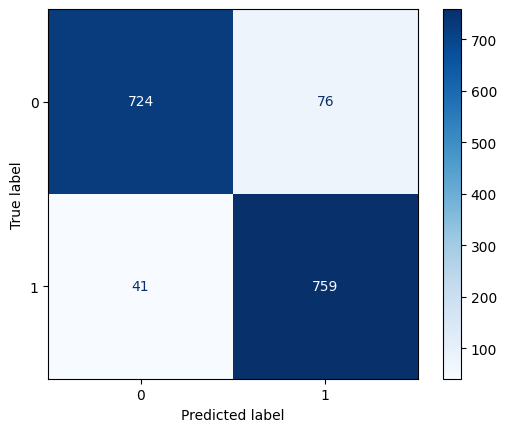

In [ ]:
# Get predictions for the train data
final_train_predictions = nbpipe2.predict(X_train)

# call the model from the pipeline
clf = nbpipe2.named_steps['clf']

# plot confusion matrix
cm = confusion_matrix(y_train, final_train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

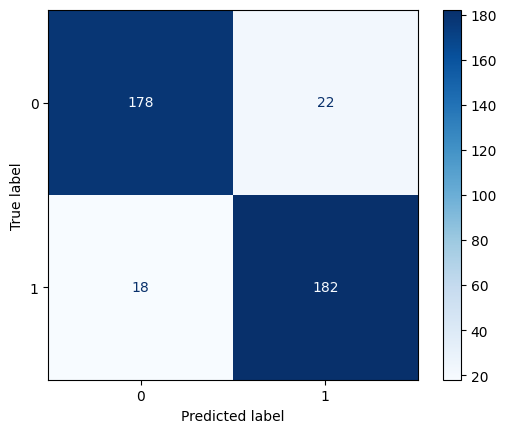

In [ ]:
# Get predictions for the test data
final_test_predictions = nbpipe2.predict(X_test)

# call the model from the pipeline
clf = nbpipe2.named_steps['clf']

# plot confusion matrix
cm = confusion_matrix(y_test, final_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

###Final Model: Main Takeaway

Accuracy, recall, precision, and F1 scores are all fairly high. The model appears to be fitting the training data well without overfitting, as evidenced by the test set results. The test set results are slightly lower than the training set but still quite strong, showing that the model generalizes well on unseen data. Eliminating the validation set also gave a larger dataset on which to train which seems to have improved model performance as well. Given the small size of the dataset (2,000 rows), the volume of false negatives and false positives falls within an acceptable margin of error for me at this time.

##Conclusion and Next Steps

Despite the inherent limitations of a small dataset created by a team of one, the final model was able to distinguish between usages of the word be with a high degree of accuracy (90%).

As I look to grow this project, I would like to:

*   Expand the corpus in collaboration with other native speakers of AAVE and linguistic experts
*   Experiment with other modeling methods (e.g. support vector machines, neural networks, etc.)
* Train models on other aspects of AAVE
